In [28]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Conv2D
from skimage.metrics import structural_similarity as ssim

In [29]:

# Skew correction function
def correct_skew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Tone mapping function
def apply_tone_mapping(image):
    ldr = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255
    tonemap = cv2.createTonemap(gamma=2.2)
    res = tonemap.process(ldr)
    res_8bit = np.clip(res * 255, 0, 255).astype(np.uint8)
    return cv2.cvtColor(res_8bit, cv2.COLOR_RGB2BGR)

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, target_size)
    image_normalized = image_resized.astype('float32') / 255.0
    return image, image_resized, image_normalized

# PSNR calculation
def calculate_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(1.0 / np.sqrt(mse))

# SSIM calculation
def calculate_ssim(y_true, y_pred, win_size=3, channel_axis=-1):
    return ssim(y_true, y_pred, win_size=win_size, channel_axis=channel_axis, data_range=1)

# SRCNN Model
def build_srcnn_model(input_shape=(256, 256, 3)):
    input_img = Input(shape=input_shape)
    l1 = Conv2D(64, 9, padding='same', activation='relu')(input_img)
    l2 = Conv2D(32, 1, padding='same', activation='relu')(l1)
    l3 = Conv2D(3, 5, padding='same', activation='relu')(l2)
    model = Model(input_img, l3)
    return model

# Compile and train the model
def train_srcnn(train_low_image, train_high_image, validation_data):
    srcnn_model = build_srcnn_model()
    srcnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')
    history = srcnn_model.fit(train_low_image, train_high_image, epochs=20, batch_size=1, validation_data=validation_data)
    return srcnn_model, history

# Load dataset for training and validation
def load_dataset(input_images_folder, n_images=1800, image_size=(256, 256)):
    high_img, low_img = [], []
    for i, img_file in enumerate(os.listdir(input_images_folder)[:n_images]):
        img = cv2.imread(os.path.join(input_images_folder, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_high = cv2.resize(img, image_size)
        img_low = cv2.resize(cv2.resize(img_high, (image_size[0]//4, image_size[1]//4)), image_size)
        img_high = img_high.astype('float32') / 255.0
        img_low = img_low.astype('float32') / 255.0
        high_img.append(img_high)
        low_img.append(img_low)
    high_img = np.array(high_img)
    low_img = np.array(low_img)
    return high_img, low_img


In [30]:
# Load and split the dataset
input_images_folder = 'input_images'
train_high_image, train_low_image = load_dataset(input_images_folder, 1500)
validation_high_image, validation_low_image = load_dataset(input_images_folder, 300)

# Train the SRCNN model
srcnn_model, history = train_srcnn(train_low_image, train_high_image, (validation_low_image, validation_high_image))


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 69ms/step - loss: 0.0106 - val_loss: 0.0028
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 103s 103ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 74ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 11/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 

In [35]:

# Save the trained model
srcnn_model.save("SRCNN_e_20.h5")

# Load the model for prediction
loadded_model = load_model('SRCNN_e_20.h5', compile=False)

# Load the test image and perform prediction
original_image_path = './test_images/test_image.jpg'
original_image, cropped_image, cropped_image_normalized = load_and_preprocess_image(original_image_path)

# Apply skew correction
skew_corrected_image = correct_skew(cropped_image)

# Make a prediction with the model
predicted_image = loadded_model.predict(np.expand_dims(cropped_image_normalized, axis=0))[0]
predicted_image = np.clip(predicted_image, 0, 1)

# Resize predicted image back to original size
predicted_image_resized = cv2.resize(predicted_image, (original_image.shape[1], original_image.shape[0]))

# Apply tone mapping
predicted_tone_mapped = apply_tone_mapping((predicted_image_resized * 255).astype(np.uint8))


# PSNR and SSIM calculation
psnr_value = calculate_psnr(cropped_image / 255.0, predicted_image)
ssim_value = calculate_ssim(cropped_image / 255.0, predicted_image, win_size=3, channel_axis=-1)
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
PSNR: 20.58 dB
SSIM: 0.5909


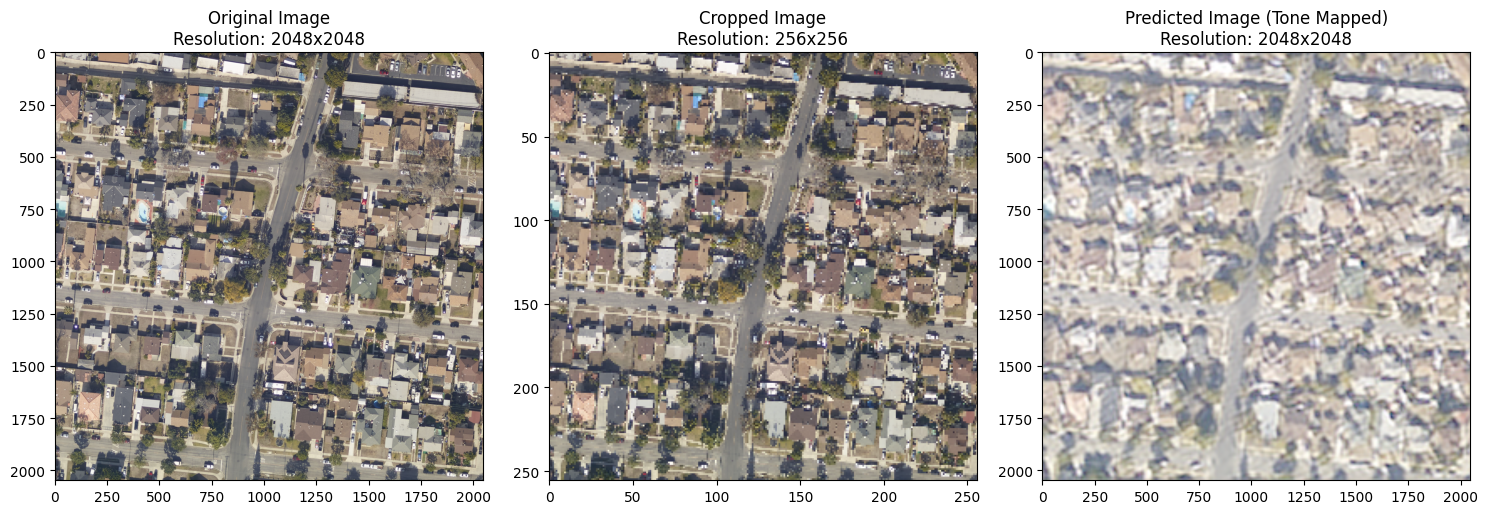

True

In [36]:
# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original Image\nResolution: {original_image.shape[0]}x{original_image.shape[1]}')
axes[1].imshow(cropped_image)
axes[1].set_title(f'Cropped Image\nResolution: {cropped_image.shape[0]}x{cropped_image.shape[1]}')
axes[2].imshow(predicted_tone_mapped)
axes[2].set_title(f'Predicted Image (Tone Mapped)\nResolution: {predicted_tone_mapped.shape[0]}x{predicted_tone_mapped.shape[1]}')

plt.tight_layout()
plt.show()

# Save the resulting images
cv2.imwrite('output_images/high_res_generated.png', predicted_tone_mapped)
cv2.imwrite('output_images/low_res_input.png', cropped_image)